In [11]:
%reload_ext autoreload 
%autoreload 2
import numpy as np
import torch
import os

from train import *
from test import *
from utils import *
from torch.utils.data import DataLoader
from data_loader import OneshotDataset
from data_loader import OneshotDataset_v2

In [12]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [13]:
class ResNet(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(ResNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_features, 500),
            nn.ReLU(),
        )
        self.block1 = nn.Sequential(

            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(500, 800),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

        )
        self.layer3 = nn.Linear(800, out_features)
    def forward(self, x):
        x = self.layer1(x)
        x = self.block1(x) + x
        x = self.layer2(x)
        x = self.block2(x) + x
        x = self.layer3(x)
        return x


In [14]:
class ResNet(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(ResNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_features, 500),
            nn.Tanh(),
        )
        self.block1 = nn.Sequential(

            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Dropout(p=dropout_rate),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(500, 800),
            nn.Tanh(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(800, 800),
            nn.Tanh(),
            nn.Linear(800, 800),
            nn.Tanh(),
            nn.Dropout(p=dropout_rate),

        )
        self.layer3 = nn.Linear(800, out_features)
    def forward(self, x):
        x = self.layer1(x)
        x = self.block1(x) + x
        x = self.layer2(x)
        x = self.block2(x) + x
        x = self.layer3(x)
        return x


In [15]:
class ResNet_sin_cos(nn.Module):
    
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(ResNet_sin_cos, self).__init__()
        self.ResNet_sin = ResNet(in_features, out_features, dropout_rate)
        self.ResNet_cos = ResNet(in_features, out_features, dropout_rate)
        
    def forward(self, x):
        y1 = self.ResNet_sin(x)
        y2 = self.ResNet_cos(x)
        return torch.stack((y1, y2), -1)

In [16]:
class ResNet_total(nn.Module):
    
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(ResNet_total, self).__init__()
        self.ResNet_A = ResNet(in_features, out_features, dropout_rate)
        self.ResNet_sin = ResNet(in_features, out_features, dropout_rate)
        self.ResNet_cos = ResNet(in_features, out_features, dropout_rate)
        self.ResNet_SR = ResNet(in_features, out_features, dropout_rate)
        self.ResNet_SI = ResNet(in_features, out_features, dropout_rate)


    def forward(self, x):
        y1 = self.ResNet_A(x)
        y2 = self.ResNet_sin(x)
        y3 = self.ResNet_cos(x)
        y4 = self.ResNet_SR(x)
        y5 = self.ResNet_SI(x)
        return torch.stack((y1, y2, y3, y4, y5), -1)

In [7]:
case = 'Differential_Stripline_W_L_Trap'
line_model = 'Stripline_Diff-Pair'
input_cols = ['W', 'Trap', 'Length']
port = 4

lr = 0.001
num_epochs = 10000
batch_size = 512

f_start = 0
f_end = 100e9
f_step = 200e6

F = np.arange(f_start, f_end + f_step, f_step)
nF = len(F)

read_idx = True # Whether to read the index list (trained already)
retrain = False # Whether to train the model

In [8]:
# read training data
df = pd.read_csv('../Data/%s.csv' % case, index_col=[0,1])

In [9]:
# get indices
indices = get_indices(df, case)
args = {}
args['beta'] = {}
args['beta']['A'] = 1
args['beta']['cosP']  = 1
args['beta']['sinP']  = 1
args['beta']['SR']  = 1
args['beta']['SI']  = 1
args['beta']['SR_diff']  = 1
args['beta']['SI_diff']  = 1
args['beta']['P']  = 1

mean_dict = {}
std_dict = {}

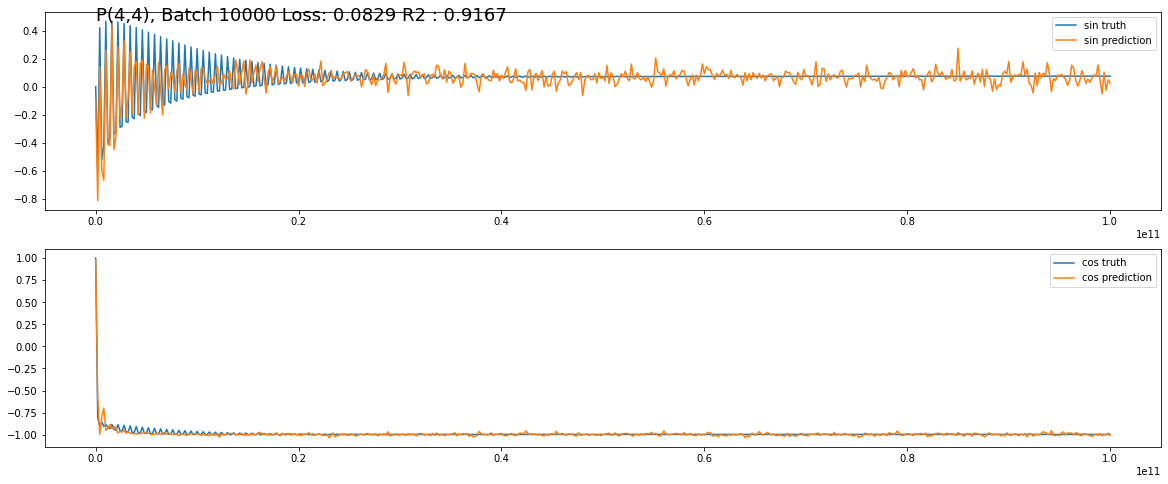

In [17]:
output_col = 'P(4,4)'

train_dataset = OneshotDataset(df, line_model, input_cols, output_col, indices['train_idx'], device, nF)
val_dataset = OneshotDataset(df, line_model, input_cols, output_col, indices['val_idx'], device, nF)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

args['path'] = get_model_path(output_col, case)
args['output_col'] = output_col
args['F'] = F
args['mean'] = train_dataset.output_mean
args['std'] = train_dataset.output_std

mean_dict[output_col] = train_dataset.output_mean
std_dict[output_col] = train_dataset.output_std

model = ResNet_sin_cos(len(input_cols), nF).to(device)
loss_func = cos_sin_loss
args['mode'] = 'cos_sin'

# train
initialize_weights(model)
model = train(model, train_dataloader, val_dataloader, lr, loss_func, num_epochs, args)

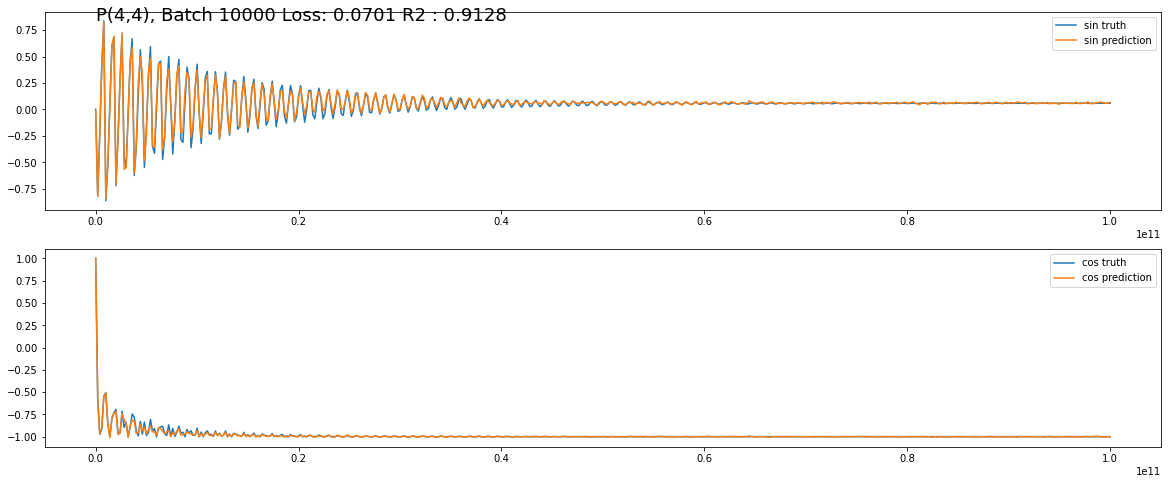

In [97]:
for i in range(port):
    for j in range(port):
        for k in 'A', 'P':
            output_col = '%s(%d,%d)' % (k, i+1, j+1)
            
            train_dataset = OneshotDataset(df, line_model, input_cols, output_col, indices['train_idx'], device, nF)
            val_dataset = OneshotDataset(df, line_model, input_cols, output_col, indices['val_idx'], device, nF)
            
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
            
            args['path'] = get_model_path(output_col, case)
            args['output_col'] = output_col
            args['F'] = F
            args['mean'] = train_dataset.output_mean
            args['std'] = train_dataset.output_std
            
            mean_dict[output_col] = train_dataset.output_mean
            std_dict[output_col] = train_dataset.output_std
         
            if k == 'A':
                model = ResNet(len(input_cols), nF).to(device)
                loss_func = mse_loss
                args['mode'] = 'single'
            else:
                model = ResNet_sin_cos(len(input_cols), nF).to(device)
                loss_func = cos_sin_loss
                args['mode'] = 'cos_sin'
            
            # train
            initialize_weights(model)
            model = train(model, train_dataloader, val_dataloader, lr, loss_func, num_epochs, args)

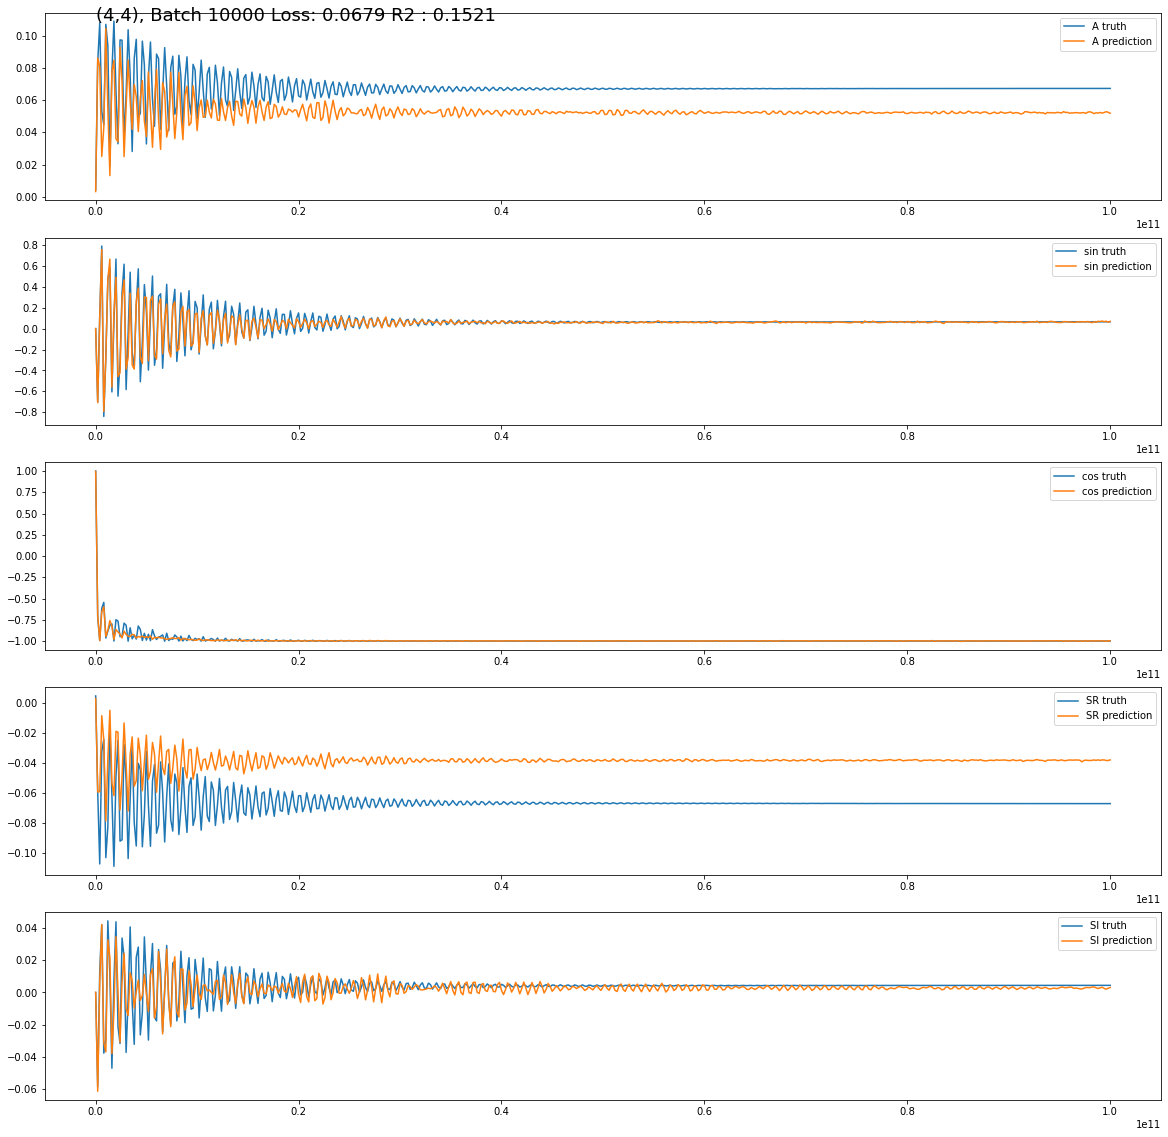

In [98]:
for i in range(port):
    for j in range(port):
        index = [i+1, j+1] 

        train_dataset = OneshotDataset_v2(df, line_model, input_cols, index, indices['train_idx'], device, nF)
        val_dataset = OneshotDataset_v2(df, line_model, input_cols, index, indices['val_idx'], device, nF)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        args['path'] = get_model_path(output_col, case)
        args['output_col'] = '(%d,%d)' % (i+1, j+1)
        args['F'] = F


        model = ResNet_total(len(input_cols), nF).to(device)
        loss_func = combined_loss
        args['mode'] = 'total'
        

        # train
        initialize_weights(model)
        model = train(model, train_dataloader, val_dataloader, lr, loss_func, num_epochs, args)